Let's fit three deep learning models to the overall arrests time series.

# Setup

1. Imports

In [70]:
#| code-fold: false
import pandas as pd
import numpy as np

2. Read in data

In [ ]:
#| code-fold: true
f = open("data/arrests_by_date.csv")
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

3. Parse data

In [37]:
#| code-fold: true
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

# normalizing the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:20000].std(axis=0)
float_data /= std

4. Create a generator for samples and targets

In [44]:
#| code-fold: true
# generator yielding timeseries samples and their targets
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][0]
        yield samples, targets

5. Preparing the training, validation, and test generators

In [45]:
#| code-fold: true
# preparing the training, validation, and test generators
lookback = 36
step = 12
delay = 24
batch_size = 24

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=100,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=101,
                      max_index=150,
                      step=step,
                      batch_size=batch_size)

test_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=151,
                      max_index=None,
                      step=step,
                      batch_size=batch_size)

val_steps = (151 - 101 - lookback)     # how many steps to draw from val_gen in order to see the entire validation set

test_steps = (len(float_data) - 151 - lookback)  # how many steps to draw from test_gen in order to see the entire test set

In [55]:
# computing the common-sense baseline MAE
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 0]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()
print(1.217 * std[0])


1.2171689202817748
10131.209167107394


We have a mean absolute error of 10,131.21 arrests each month.

# RNN

In [89]:
#| output: false
#| code-fold: true
# insert rnn model
# training and evaluating an LSTM model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()
model.add(layers.SimpleRNN(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=RootMeanSquaredError())
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

rnn_rmse = history.history['val_root_mean_squared_error']


Epoch 1/20


/var/folders/5d/p4q7qjsj2wz4ph_q3kp6fkvw0000gn/T/ipykernel_19428/30317983.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,
2023-11-28 20:23:58.225182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 1s 739us/step - loss: 0.2758 - root_mean_squared_error: 0.3658 - val_loss: 1.2141 - val_root_mean_squared_error: 1.2757
Epoch 2/20
204/500 [===========>..................] - ETA: 0s - loss: 0.2736 - root_mean_squared_error: 0.3630

2023-11-28 20:23:58.886042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 0s 531us/step - loss: 0.2697 - root_mean_squared_error: 0.3585 - val_loss: 1.1534 - val_root_mean_squared_error: 1.2147
Epoch 3/20
500/500 [==============================] - 0s 609us/step - loss: 0.2665 - root_mean_squared_error: 0.3567 - val_loss: 1.1624 - val_root_mean_squared_error: 1.2156
Epoch 4/20
500/500 [==============================] - 0s 544us/step - loss: 0.2617 - root_mean_squared_error: 0.3519 - val_loss: 1.1294 - val_root_mean_squared_error: 1.1885
Epoch 5/20
500/500 [==============================] - 0s 530us/step - loss: 0.2669 - root_mean_squared_error: 0.3584 - val_loss: 1.1284 - val_root_mean_squared_error: 1.1833
Epoch 6/20
500/500 [==============================] - 0s 541us/step - loss: 0.2612 - root_mean_squared_error: 0.3512 - val_loss: 1.1008 - val_root_mean_squared_error: 1.1632
Epoch 7/20
500/500 [==============================] - 0s 650us/step - loss: 0.2593 - root_mean_squared_error: 0.3474 - val_loss: 1.1153 - val

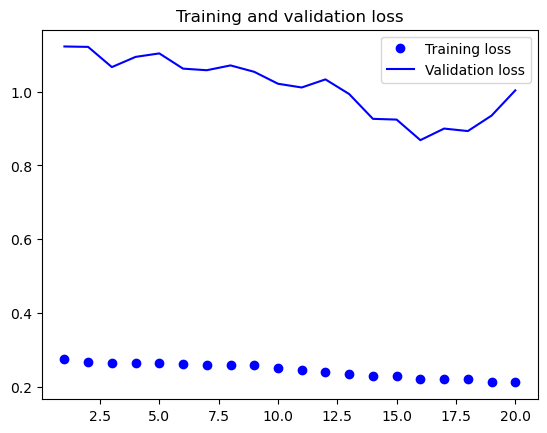

In [67]:
#| echo: false
# plotting result
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

There is a significant gap between training and validation loss, suggesting overfitting is occuring.

# GRU

In [90]:
#| output: false
#| code-fold: true
# training and evaluating a GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=RootMeanSquaredError())
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

gru_rmse = history.history['val_root_mean_squared_error']

Epoch 1/20


2023-11-28 20:24:25.326272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-28 20:24:25.326992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-28 20:24:25.327455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

500/500 [==============================] - 2s 1ms/step - loss: 0.2972 - root_mean_squared_error: 0.3942 - val_loss: 1.2792 - val_root_mean_squared_error: 1.3392
Epoch 2/20


2023-11-28 20:24:26.700238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-28 20:24:26.794257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-28 20:24:26.794901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

500/500 [==============================] - 0s 908us/step - loss: 0.2727 - root_mean_squared_error: 0.3644 - val_loss: 1.2406 - val_root_mean_squared_error: 1.3050
Epoch 3/20
500/500 [==============================] - 1s 1ms/step - loss: 0.2645 - root_mean_squared_error: 0.3562 - val_loss: 1.2541 - val_root_mean_squared_error: 1.3154
Epoch 4/20
500/500 [==============================] - 0s 898us/step - loss: 0.2625 - root_mean_squared_error: 0.3543 - val_loss: 1.2276 - val_root_mean_squared_error: 1.2893
Epoch 5/20
500/500 [==============================] - 0s 943us/step - loss: 0.2595 - root_mean_squared_error: 0.3501 - val_loss: 1.2561 - val_root_mean_squared_error: 1.3160
Epoch 6/20
500/500 [==============================] - 0s 994us/step - loss: 0.2649 - root_mean_squared_error: 0.3575 - val_loss: 1.2304 - val_root_mean_squared_error: 1.2894
Epoch 7/20
500/500 [==============================] - 0s 959us/step - loss: 0.2599 - root_mean_squared_error: 0.3498 - val_loss: 1.1820 - val_r

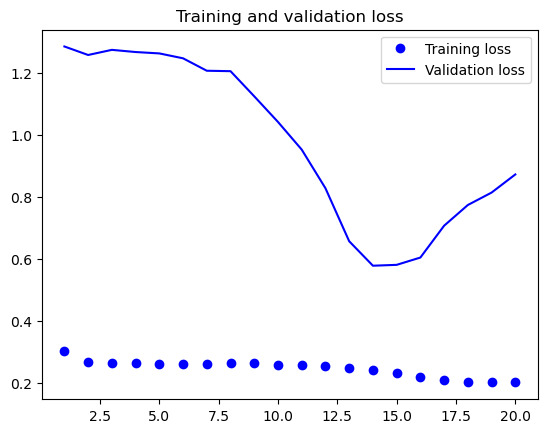

In [57]:
#| echo: false
#| code-fold: true
# plotting result
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Eventually, around epoch 14, the gap between training and validation loss becomes fairly small, at least smaller than the first RNN model. This is a good sign, and means we may not be overfitting in this model. However, early stopping might be useful here as validation loss increases after that point while the trainin loss does not. This GRU model was useful, we should attempt to fit a dropout-regularized GRU model. 

## Dropout-regularized GRU

In [91]:
#| output: false
#| code-fold: true
# training and evaluating a GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, 
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=RootMeanSquaredError())
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

rgru_rmse = history.history['val_root_mean_squared_error']

Epoch 1/40


/var/folders/5d/p4q7qjsj2wz4ph_q3kp6fkvw0000gn/T/ipykernel_19428/856307784.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,
2023-11-28 20:24:39.002248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 2s 1ms/step - loss: 0.3387 - root_mean_squared_error: 0.4387 - val_loss: 1.7549 - val_root_mean_squared_error: 1.7949
Epoch 2/40
  1/500 [..............................] - ETA: 0s - loss: 0.3628 - root_mean_squared_error: 0.4769

2023-11-28 20:24:40.502093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


500/500 [==============================] - 1s 1ms/step - loss: 0.3291 - root_mean_squared_error: 0.4306 - val_loss: 1.7000 - val_root_mean_squared_error: 1.7422
Epoch 3/40
500/500 [==============================] - 1s 1ms/step - loss: 0.3252 - root_mean_squared_error: 0.4276 - val_loss: 1.6612 - val_root_mean_squared_error: 1.7055
Epoch 4/40
500/500 [==============================] - 1s 1ms/step - loss: 0.3143 - root_mean_squared_error: 0.4111 - val_loss: 1.4361 - val_root_mean_squared_error: 1.4876
Epoch 5/40
500/500 [==============================] - 1s 1ms/step - loss: 0.3155 - root_mean_squared_error: 0.4123 - val_loss: 1.5108 - val_root_mean_squared_error: 1.5559
Epoch 6/40
500/500 [==============================] - 1s 1ms/step - loss: 0.3118 - root_mean_squared_error: 0.4061 - val_loss: 1.3909 - val_root_mean_squared_error: 1.4387
Epoch 7/40
500/500 [==============================] - 1s 1ms/step - loss: 0.3021 - root_mean_squared_error: 0.3993 - val_loss: 1.3737 - val_root_mean_s

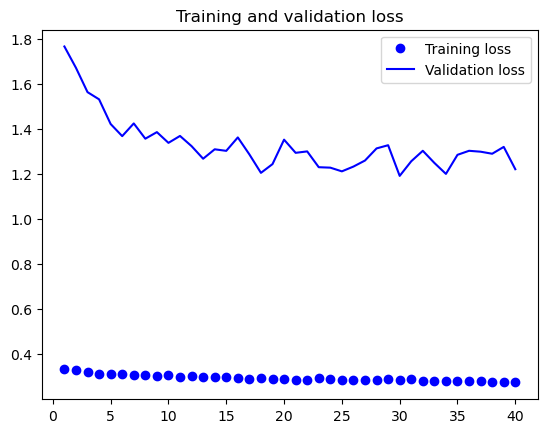

In [72]:
#| echo: false
#| code-fold: true
# plotting result
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

This one looks worse than the previous model, there is more evidence of overfitting.

# LSTM

In [92]:
#| output: false
#| code-fold: true
# training and evaluating an LSTM model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=[RootMeanSquaredError()])
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

ltsm_rmse = history.history['val_root_mean_squared_error']

Epoch 1/20


2023-11-28 20:25:13.017525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-28 20:25:13.018206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-28 20:25:13.018809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

448/500 [=========================>....] - ETA: 0s - loss: 0.3101 - root_mean_squared_error: 0.4088

2023-11-28 20:25:14.902006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-11-28 20:25:14.995264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-28 20:25:14.995990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

500/500 [==============================] - 2s 1ms/step - loss: 0.3067 - root_mean_squared_error: 0.4053 - val_loss: 1.4014 - val_root_mean_squared_error: 1.4492
Epoch 2/20
500/500 [==============================] - 1s 1ms/step - loss: 0.2756 - root_mean_squared_error: 0.3684 - val_loss: 1.2768 - val_root_mean_squared_error: 1.3384
Epoch 3/20
500/500 [==============================] - 1s 1ms/step - loss: 0.2659 - root_mean_squared_error: 0.3558 - val_loss: 1.2789 - val_root_mean_squared_error: 1.3385
Epoch 4/20
500/500 [==============================] - 1s 1ms/step - loss: 0.2647 - root_mean_squared_error: 0.3575 - val_loss: 1.2855 - val_root_mean_squared_error: 1.3434
Epoch 5/20
500/500 [==============================] - 0s 989us/step - loss: 0.2658 - root_mean_squared_error: 0.3590 - val_loss: 1.2890 - val_root_mean_squared_error: 1.3472
Epoch 6/20
500/500 [==============================] - 0s 923us/step - loss: 0.2630 - root_mean_squared_error: 0.3535 - val_loss: 1.2504 - val_root_me

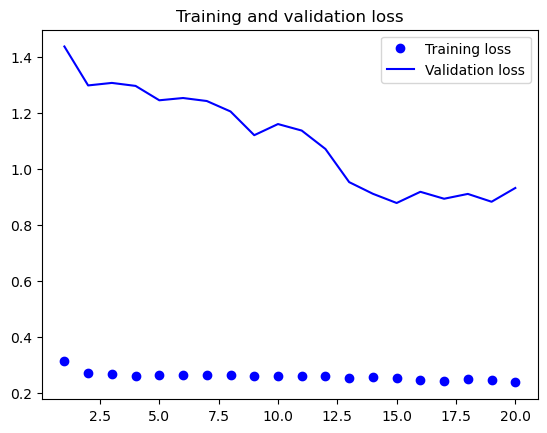

In [65]:
#| echo: false
#| code-fold: true
# plotting result
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The output of this model looks similar to the original RNN model. The gap between training and validation loss is large, suggesting overfitting. The GRU model was by far the best model. 

# Comparison

In [94]:
#| code-fold: true

print(f"RNN RMSE: {round(min(rnn_rmse), 4)} at epoch {rnn_rmse.index(min(rnn_rmse)) +1}")
print(f"GRU RMSE: {round(min(gru_rmse), 4)} at epoch {gru_rmse.index(min(gru_rmse)) +1}")
print(f"Dropout-Regularized GRU RMSE: {round(min(rgru_rmse), 4)} at epoch {rgru_rmse.index(min(rgru_rmse)) +1}")
print(f"LSTM RMSE: {round(min(ltsm_rmse), 4)} at epoch {ltsm_rmse.index(min(ltsm_rmse)) +1}")

RNN RMSE: 0.9021 at epoch 18
GRU RMSE: 0.6959 at epoch 14
Dropout-Regularized GRU RMSE: 1.2831 at epoch 28
LSTM RMSE: 0.9617 at epoch 17


This validates what we saw earlier, GRU appears to be the best model at epoch 14. However, this is still lower than the RMSE of our SARIMA(1, 1, 1)(1, 1, 1)12 model fitted earlier, as that had an RMSE of 0.3043.

# Forecasting

In [ ]:
#| include: false
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae', metrics=RootMeanSquaredError())
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

7/7 [==============================] - 0s 499us/step


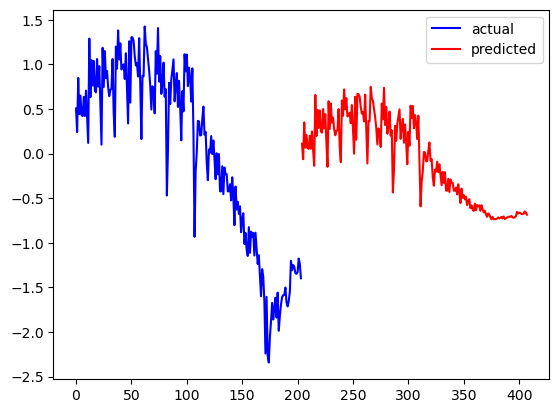

In [103]:
predictions = model.predict(float_data)
future_timestamps = np.arange(len(float_data), len(float_data) + len(predictions))

plt.plot(float_data, label = 'actual', color = 'blue')
plt.plot(future_timestamps, predictions, label='predicted', color='red')
plt.legend()
plt.show()

It appears that the predicted values are above the current rate, meaning the current arrests rate is lower than it should be. 